<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Building Hourly Demand and Merging with Meteostat Weather
  </span>
</h3>

Loads the cleaned CitiBike trips and the processed Meteostat-based hourly weather data,<br>
aggregates trips to an hourly time series, and merges both sources into combined datasets <br>
at trip level and at hourly level for subsequent analysis.


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Paths
trips_path = "../data/Trips_2018_clean.csv"
weather_path = "../data/Weather_Data/processed/central_park_weather_2018_meteostat_hourly.csv"

# Load data
trips = pd.read_csv(trips_path)
weather = pd.read_csv(weather_path, parse_dates=["datetime"])

# Ensure start_time is datetime
trips["start_time"] = pd.to_datetime(trips["start_time"], errors="coerce")

# Floor to hourly timestamps
trips["datetime_hour"] = trips["start_time"].dt.floor("H")

# Hourly demand (system-level)
demand_hourly = (
    trips
    .groupby("datetime_hour")
    .size()
    .reset_index(name="pickups")
)

# --- Merge 1: trip-level merge (keep all columns from both datasets) ---
merged_trips_weather = trips.merge(
    weather,
    how="left",
    left_on="datetime_hour",
    right_on="datetime"
)

# --- Merge 2: hourly demand + weather (aggregated view) ---
demand_hourly_weather = demand_hourly.merge(
    weather,
    how="left",
    left_on="datetime_hour",
    right_on="datetime"
)

# Basic stats
print("=== Rows / hours overview ===")
print(f"Trips rows:                     {len(trips):,}")
print(f"Weather rows (hourly):          {len(weather):,}")
print(f"Unique hours in trips:          {trips['datetime_hour'].nunique():,}")
print(f"Unique hours in weather:        {weather['datetime'].nunique():,}")
print(f"Trip-level merged rows:         {len(merged_trips_weather):,}")
print(f"Hourly demand+weather rows:     {len(demand_hourly_weather):,}")

# How many trip rows have missing weather?
missing_weather_rows = merged_trips_weather["temp_C"].isna().sum()
print(f"Trip rows with missing weather: {missing_weather_rows:,}")

merged_trips_weather.head()

C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\2116900024.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips["datetime_hour"] = trips["start_time"].dt.floor("H")


=== Rows / hours overview ===
Trips rows:                     17,480,683
Weather rows (hourly):          8,761
Unique hours in trips:          8,743
Unique hours in weather:        8,761
Trip-level merged rows:         17,480,683
Hourly demand+weather rows:     8,743
Trip rows with missing weather: 0


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,...,pres,tsun,coco,temp_C,pressure_inHg,wind_speed_kn,precip_in,is_rain,is_snow_like,is_dry
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,...,1028.7,NaN,NaN,-11.7,30.377494,4.103673,0.0,False,False,True
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,...,1029.4,NaN,NaN,-9.4,30.398165,2.915768,0.0,False,False,True
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,...,1029.4,NaN,NaN,-9.4,30.398165,2.915768,0.0,False,False,True
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,...,1029.4,NaN,NaN,-9.4,30.398165,2.915768,0.0,False,False,True
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,...,1027.9,NaN,NaN,-5.6,30.353870,6.047518,0.0,False,False,True


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Missing Values in Trip-Level Weather Columns
  </span>
</h3>

Counts missing values for each key weather variable in the trip-level dataset.</br>
No trips are missing temperature or wind speed, while only 8 630 trips lack pressure</br>
and 543 308 trips lack precipitation. These correspond to a small fraction of the</br>
17.5M total trips and are caused by a few hours without pressure or precipitation</br>
data being repeated across many trips.

In [3]:
merged_trips_weather[["temp_C", "pressure_inHg", "wind_speed_kn", "precip_in"]].isna().sum()

temp_C                0
pressure_inHg      8630
wind_speed_kn         0
precip_in        543308
dtype: int64

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Share of Missing Weather per Trip
  </span>
</h3>

Computes the proportion of trips with missing temperature, pressure, and precipitation.</br>
Temperature is available for 100% of trips, pressure is missing for about 0.05% of trips,</br>
and precipitation for about 3.1% of trips. These percentages indicate that the loss of</br>
information at trip level is very small and acceptable for analysis.

In [4]:
merged_trips_weather[["temp_C", "pressure_inHg", "precip_in"]].isna().sum() / len(merged_trips_weather)


temp_C           0.000000
pressure_inHg    0.000494
precip_in        0.031080
dtype: float64

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Missing Values in Hourly Demand & Weather
  </span>
</h3>

Checks missing values in the hourly demand–weather dataset. All hours have temperature</br>
and wind speed, only 8 hours lack pressure, and 350 hours (around 4% of the year) lack</br>
precipitation. Since the time coverage is complete (one row per hour in 2018) and the</br>
share of missing values is low, the dataset is suitable for reliable hourly analysis.

In [5]:
demand_hourly_weather[["temp_C", "pressure_inHg", "wind_speed_kn", "precip_in"]].isna().sum()

temp_C             0
pressure_inHg      8
wind_speed_kn      0
precip_in        350
dtype: int64

In [6]:
demand_hourly_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8743 entries, 0 to 8742
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime_hour  8743 non-null   datetime64[ns]
 1   pickups        8743 non-null   int64         
 2   datetime       8743 non-null   datetime64[ns]
 3   temp           8743 non-null   float64       
 4   dwpt           8743 non-null   float64       
 5   rhum           8743 non-null   float64       
 6   prcp           8393 non-null   float64       
 7   snow           0 non-null      float64       
 8   wdir           8739 non-null   float64       
 9   wspd           8743 non-null   float64       
 10  wpgt           0 non-null      float64       
 11  pres           8735 non-null   float64       
 12  tsun           0 non-null      float64       
 13  coco           5754 non-null   float64       
 14  temp_C         8743 non-null   float64       
 15  pressure_inHg  8735 n

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Creating Time-Based Features
  </span>
</h3>

Derives calendar features from the hourly timestamp: the hour of day, the day of week, a weekend</br>
indicator, and the month. These variables are later used to describe baseline demand patterns and</br>
to control for regular temporal effects when analysing the impact of weather.

In [7]:
# Add time-based features
demand_hourly_weather["hour"] = demand_hourly_weather["datetime_hour"].dt.hour
demand_hourly_weather["dow"] = demand_hourly_weather["datetime_hour"].dt.dayofweek
demand_hourly_weather["is_weekend"] = demand_hourly_weather["dow"] >= 5
demand_hourly_weather["month"] = demand_hourly_weather["datetime_hour"].dt.month

In [8]:
required_cols = [
    "datetime_hour",
    "pickups",
    "temp_C",
    "precip_in",
    "wind_speed_kn",
    "rhum",
    "is_rain",
    "is_snow_like",
    "is_dry",
    "hour",
    "dow",
    "is_weekend",
    "month",
]

demand_core = demand_hourly_weather[required_cols].copy()



In [9]:
# Check missing values for the required columns
missing_counts = demand_core[required_cols].isna().sum()
total_rows = len(demand_core)

missing_summary = (
    pd.DataFrame({
        "missing_count": missing_counts,
        "missing_percent": (missing_counts / total_rows) * 100
    })
    .sort_values("missing_percent", ascending=False)
)

missing_summary

,missing_count,missing_percent
precip_in,350,4.003203
is_dry,350,4.003203
is_rain,345,3.946014
is_snow_like,5,0.057189
datetime_hour,0,0.000000
wind_speed_kn,0,0.000000
temp_C,0,0.000000
pickups,0,0.000000
rhum,0,0.000000
hour,0,0.000000


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Ensuring Complete Weather Information
  </span>
</h3>

Removes all hours without precipitation measurements, so that every remaining row has a valid value for <code>precip_in</code>.  
Based on the cleaned precipitation and temperature, the weather condition flags (<code>is_rain</code>, <code>is_snow_like</code>, <code>is_dry</code>) are recomputed to be fully consistent.  
Finally, a summary table of missing values is created to verify that no core variables contain NaN after this filtering step.

In [10]:
# 1) Drop hours without precipitation info
demand_core = demand_core.dropna(subset=["precip_in"]).copy()

# 2) Recompute weather flags to be fully consistent
demand_core["is_rain"] = (demand_core["precip_in"] > 0) & (demand_core["temp_C"] > 0)
demand_core["is_snow_like"] = (demand_core["precip_in"] > 0) & (demand_core["temp_C"] <= 0)
demand_core["is_dry"] = demand_core["precip_in"] == 0

# 3)  Check again for NaN
missing_counts = demand_core.isna().sum()
total_rows = len(demand_core)

missing_summary = (
    pd.DataFrame({
        "missing_count": missing_counts,
        "missing_percent": (missing_counts / total_rows) * 100
    })
    .sort_values("missing_percent", ascending=False)
)

missing_summary

,missing_count,missing_percent
datetime_hour,0,0.0
pickups,0,0.0
temp_C,0,0.0
precip_in,0,0.0
wind_speed_kn,0,0.0
rhum,0,0.0
is_rain,0,0.0
is_snow_like,0,0.0
is_dry,0,0.0
hour,0,0.0


-------------------------------------------------------------------------------------------</br>
-------------------------------------------------------------------------------------------</br>

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Creating Temperature Bands (temp_bin)
  </span>
</h3>

Defines temperature bands using <code>pd.cut</code> so that hourly demand can be grouped </br>
into intuitive ranges (e.g. 0–5°C, 10–15°C, 20–25°C) for later comparison across scenarios.

In [11]:
# Define bins and labels for temperature in °C
temp_bins = [-20, 0, 5, 10, 15, 20, 25, 30, 50]
temp_labels = ["<0", "0-5", "5-10", "10-15", "15-20", "20-25", "25-30", ">30"]

# Add categorical temperature bin
demand_core["temp_bin"] = pd.cut(
    demand_core["temp_C"],
    bins=temp_bins,
    labels=temp_labels,
    right=False  # intervals are [a, b)
)

# Quick check: how many hours in each bin
temp_bin_counts = demand_core["temp_bin"].value_counts().sort_index()
print("Hours per temperature bin:")
print(temp_bin_counts)

Hours per temperature bin:
temp_bin
<0        538
0-5      1299
5-10     1580
10-15    1049
15-20    1008
20-25    1519
25-30    1066
>30       334
Name: count, dtype: int64


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Selecting Baseline Conditions (Dry Weekdays, 10–15&nbsp;°C)
  </span>
</h3>

Builds a baseline subset of hours with dry weather, weekdays, and temperatures between </br>
10&nbsp;and&nbsp;15&nbsp;°C. This subset represents "normal" conditions and will be used as a </br>
reference when quantifying the impact of other weather scenarios on demand.


In [12]:

baseline_mask = (
    (demand_core["is_dry"] == True) &          # dry (no precipitation)
    (demand_core["is_weekend"] == False) &     # weekday
    (demand_core["temp_bin"] == "10-15")       # temp bin 10–15 °C
)

baseline_df = demand_core[baseline_mask].copy()
print("\nBaseline rows:", len(baseline_df))


Baseline rows: 465


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Baseline Demand Profile by Hour of Day
  </span>
</h3>

Computes the average number of pickups per hour of day under baseline conditions</br>
and counts how many baseline hours are available for each hour. This baseline </br>
profile serves as the reference level when building scenario-based comparisons.

In [13]:
# For each hour (0–23), compute:
# mean pickups under baseline conditions
# number of baseline hours available (n_hours)
baseline_by_hour = (
    baseline_df
    .groupby("hour")["pickups"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "baseline_pickups", "count": "n_hours"})
    .reset_index()
    .sort_values("hour")
)

print("\nBaseline profile by hour (weekdays, dry, 10–15°C):")
print(baseline_by_hour)

# Optional: check if some hours have no baseline rows
missing_hours = set(range(24)) - set(baseline_by_hour["hour"])
if missing_hours:
    print("\nWarning: no baseline data for hours:", sorted(missing_hours))
else:
    print("\nBaseline data available for all 24 hours.")


Baseline profile by hour (weekdays, dry, 10–15°C):
    hour  baseline_pickups  n_hours
0      0        289.259259       27
1      1        153.900000       20
2      2         95.550000       20
3      3         58.000000       23
4      4         90.826087       23
5      5        444.473684       19
6      6       1631.428571       21
7      7       3571.523810       21
8      8       5659.523810       21
9      9       3829.100000       20
10    10       2206.411765       17
11    11       2212.333333       18
12    12       2526.571429       14
13    13       2738.705882       17
14    14       2968.142857       14
15    15       2995.250000       16
16    16       3870.000000       10
17    17       5505.500000       16
18    18       5024.727273       22
19    19       3098.458333       24
20    20       2061.791667       24
21    21       1484.600000       15
22    22       1050.000000       21
23    23        651.090909       22

Baseline data available for all 24 hours.


-------------------------------------------------------------------------------------------</br>
-------------------------------------------------------------------------------------------</br>

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Defining Scenario Categories (day_type, rain_flag)
  </span>
</h3>

Creates high-level weather–calendar categories for each hour, distinguishing between </br>
weekday/weekend and dry/rain/snow-like conditions. These labels will be used to </br>
group hours into interpretable demand scenarios.

In [14]:
# Work on a copy to keep demand_core intact
dc = demand_core.copy()

# Weekday / weekend label
dc["day_type"] = np.where(dc["is_weekend"], "weekend", "weekday")

# Rain / snow / dry label based on the cleaned flags
dc["rain_flag"] = np.select(
    condlist=[
        dc["is_rain"],
        dc["is_snow_like"],
        dc["is_dry"],
    ],
    choicelist=["rain", "snow_like", "dry"],
    default="other"
)

dc[["datetime_hour", "pickups", "temp_C", "temp_bin", "day_type", "rain_flag"]].head()

,datetime_hour,pickups,temp_C,temp_bin,day_type,rain_flag
1,2018-01-01 01:00:00,167,-9.4,<0,weekday,dry
2,2018-01-01 02:00:00,98,-10.0,<0,weekday,dry
3,2018-01-01 03:00:00,72,-10.6,<0,weekday,dry
4,2018-01-01 04:00:00,34,-10.6,<0,weekday,dry
5,2018-01-01 05:00:00,26,-10.6,<0,weekday,dry


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Computing Scenario-Level Demand Statistics
  </span>
</h3>

Aggregates the hourly data by scenario (hour × day_type × temp_bin × rain_flag) and </br>
calculates, for each scenario, the average number of pickups and the number of hours </br>
available. This produces the basic scenario statistics table.


In [15]:
# Grouping keys for scenario definition
group_cols = ["hour", "day_type", "temp_bin", "rain_flag"]

scenario_stats = (
    dc
    .groupby(group_cols)["pickups"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "scenario_mean", "count": "n_hours"})
    .reset_index()
)

print("Raw scenario_stats shape:", scenario_stats.shape)
scenario_stats.head()

Raw scenario_stats shape: (1152, 6)


C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\2285867349.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_cols)["pickups"]


,hour,day_type,temp_bin,rain_flag,scenario_mean,n_hours
0,0,weekday,<0,dry,114.583333,12
1,0,weekday,<0,rain,NaN,0
2,0,weekday,<0,snow_like,130.000000,3
3,0,weekday,0-5,dry,220.458333,24
4,0,weekday,0-5,rain,150.125000,8


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Linking Scenarios to Baseline and Measuring Relative Change
  </span>
</h3>

Merges each scenario with the baseline demand profile by hour and computes the </br>
relative change in demand (Δ%) compared to baseline conditions. Hours without a </br>
positive baseline are removed to avoid unstable percentage ratios.

In [16]:
# baseline_by_hour must already exist: columns ["hour", "baseline_pickups"]
baseline_for_merge = baseline_by_hour[["hour", "baseline_pickups"]]

scenario_table = scenario_stats.merge(
    baseline_for_merge,
    on="hour",
    how="left"
)

# Keep only hours where baseline demand is strictly positive
scenario_table = scenario_table[scenario_table["baseline_pickups"] > 0].copy()

# Relative change vs baseline (Δ%)
scenario_table["relative_change_vs_baseline"] = (
    (scenario_table["scenario_mean"] - scenario_table["baseline_pickups"])
    / scenario_table["baseline_pickups"]
)

scenario_table.head()

,hour,day_type,temp_bin,rain_flag,scenario_mean,n_hours,baseline_pickups,relative_change_vs_baseline
0,0,weekday,<0,dry,114.583333,12,289.259259,-0.603873
1,0,weekday,<0,rain,NaN,0,289.259259,NaN
2,0,weekday,<0,snow_like,130.000000,3,289.259259,-0.550576
3,0,weekday,0-5,dry,220.458333,24,289.259259,-0.237852
4,0,weekday,0-5,rain,150.125000,8,289.259259,-0.481002


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Filtering Stable Scenarios for Analysis
  </span>
</h3>

Keeps only scenarios supported by a sufficient number of hours, ensuring that the </br>
estimated effects are based on enough observations. The final cleaned scenario table </br>
is sorted for easier inspection and ready to be used for business rules.

In [17]:
# Filter out scenarios with too few hours and missing baseline
scenario_table_clean = scenario_table[
    (scenario_table["n_hours"] >= 5) &
    (scenario_table["baseline_pickups"].notna())
].copy()

scenario_table_clean = scenario_table_clean.sort_values(
    ["day_type", "rain_flag", "temp_bin", "hour"]
)

print("Filtered scenario_table_clean shape:", scenario_table_clean.shape)
scenario_table_clean.head()

Filtered scenario_table_clean shape: (488, 8)


,hour,day_type,temp_bin,rain_flag,scenario_mean,n_hours,baseline_pickups,relative_change_vs_baseline
0,0,weekday,<0,dry,114.583333,12,289.259259,-0.603873
48,1,weekday,<0,dry,59.625000,16,153.900000,-0.612573
96,2,weekday,<0,dry,33.062500,16,95.550000,-0.653977
144,3,weekday,<0,dry,25.250000,16,58.000000,-0.564655
192,4,weekday,<0,dry,46.562500,16,90.826087,-0.487344


-------------------------------------------------------------------------------------------</br>
-------------------------------------------------------------------------------------------</br>

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Regression Setup and Target Transformation
  </span>
</h3>

Creates a working copy of the hourly dataset, keeps only hours with positive demand,</br>
and defines the regression target as <code>log1p(pickups)</code>. The rain flag is also</br>
converted from boolean to numeric for use as a feature.


In [18]:
# Working copy
df = demand_core.copy()

# Keep only hours with at least one pickup
df = df[df["pickups"] > 0].copy()

# Log-transform target to stabilize variance
df["log_pickups"] = np.log1p(df["pickups"])

# Boolean to numeric for regression
df["is_rain_int"] = df["is_rain"].astype(int)

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Feature Construction: Time and Weather Effects
  </span>
</h3>

Builds two sets of features:  </br>
(1) a base design matrix with only time dummies (hour, day-of-week), and  </br>
(2) an extended matrix which adds temperature, a rain indicator, and an interaction</br>
between temperature and rain.


In [19]:
# Categorical time variables
cat_cols = ["hour", "dow"]

# One-hot encode hour and day-of-week
X_cat = pd.get_dummies(
    df[cat_cols].astype("category"),
    drop_first=True  # avoid full multicollinearity
)

# Base model: only time effects
X_base = X_cat.copy()

# Extended model: time + weather
X_weather = pd.concat(
    [
        X_cat,
        df[["temp_C", "is_rain_int"]],
    ],
    axis=1
)

# Interaction: effect of temperature when it rains
X_weather["tempC_x_rain"] = X_weather["temp_C"] * X_weather["is_rain_int"]

# Regression target
y = df["log_pickups"]

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Time-Based Train–Test Split and Model Estimation
  </span>
</h3>

Splits the data into train and test sets based on calendar time </br>
(train: January–October, test: November–December) and fits two linear models:</br>
a base model with only time dummies and an extended model including weather variables.


In [20]:
# Time-based split: train = Jan–Oct, test = Nov–Dec
train_mask = df["datetime_hour"] < pd.Timestamp("2018-11-01")

X_base_train = X_base[train_mask]
X_base_test  = X_base[~train_mask]

X_weather_train = X_weather[train_mask]
X_weather_test  = X_weather[~train_mask]

y_train = y[train_mask]
y_test  = y[~train_mask]

print("Train rows:", len(y_train))
print("Test rows :", len(y_test))

# Fit both models
model_base = LinearRegression()
model_base.fit(X_base_train, y_train)

model_weather = LinearRegression()
model_weather.fit(X_weather_train, y_train)

Train rows: 6994
Test rows : 1399


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Model Comparison and Interpretation of Weather Coefficients
  </span>
</h3>

Compares the explanatory power of the base and extended models using R² on train and</br>
test sets. Then extracts the weather-related coefficients from the extended model</br>
to be translated into practical statements about the impact of temperature and rain</br>
on demand.


In [21]:
def evaluate(model, Xtr, Xte, ytr, yte, label):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    print(f"\n=== {label} ===")
    print("Train R^2:", round(r2_score(ytr, ytr_pred), 3))
    print("Test  R^2:", round(r2_score(yte, yte_pred), 3))

# Compare base vs time+weather models
evaluate(model_base, X_base_train, X_base_test, y_train, y_test, "Base (time only)")
evaluate(model_weather, X_weather_train, X_weather_test, y_train, y_test, "Time + weather")

# Inspect weather-related coefficients
coef_weather = pd.Series(model_weather.coef_, index=X_weather.columns)

print("\nWeather-related coefficients (on log_pickups):")
print(coef_weather[["temp_C", "is_rain_int", "tempC_x_rain"]])


=== Base (time only) ===
Train R^2: 0.753
Test  R^2: 0.735

=== Time + weather ===
Train R^2: 0.851
Test  R^2: 0.805

Weather-related coefficients (on log_pickups):
temp_C          0.041796
is_rain_int    -0.460730
tempC_x_rain    0.011003
dtype: float64


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    Interpreting Weather Coefficients in Percentage Terms
  </span>
</h3>

This step translates the regression coefficients into approximate percentage 
changes in demand:

- The temperature coefficient (<code>temp_C</code>) is denoted by β.  </br>
  A +5°C increase corresponds approximately to a percentage change of </br>
  <code>exp(5 · β) − 1</code> in demand.</br>

- The coefficients for <code>is_rain_int</code> and the interaction term </br>
  <code>tempC_x_rain</code> describe how demand changes when it rains at a given </br>
  temperature (e.g. 10°C), using <code>exp(β_rain + 10 · β_int) − 1</code>.</br>

The printed values can be directly reported as “+5°C ⇒ about +X% demand” or 
“rain at 10°C ⇒ about −Y% demand”.


In [22]:
# Extract weather-related coefficients
beta_temp = coef_weather["temp_C"]
beta_rain = coef_weather["is_rain_int"]
beta_int  = coef_weather["tempC_x_rain"]

# Example 1: effect of +5°C under dry conditions
delta_5C_dry = (np.exp(5 * beta_temp) - 1) * 100
print("Approx % change in demand for +5°C (dry hours):", round(delta_5C_dry, 1), "%")

# Example 2: effect of rain at 10°C (rain dummy + interaction)
effect_rain_10C = (np.exp(beta_rain + 10 * beta_int) - 1) * 100
print("Approx % change when it rains at 10°C:", round(effect_rain_10C, 1), "%")


Approx % change in demand for +5°C (dry hours): 23.2 %
Approx % change when it rains at 10°C: -29.6 %


-------------------------------------------------------------------------------------------</br>
-------------------------------------------------------------------------------------------</br>

<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    4.1 – Scenario Demand: Multipliers and Expected Pickups
  </span>
</h3>
This step turns the scenario table into an explicit demand forecast per hour and scenario.</br>
For each combination of hour, day type, temperature bin and rain flag, the table</br>
<code>scenario_table_clean</code> already stores:</br>
- <code>baseline_pickups</code>: typical demand under baseline conditions (dry weekday, 10–15°C).</br>
- <code>relative_change_vs_baseline</code>: average relative change vs the baseline (Δ%).</br>

A new DataFrame <code>scenario_demand</code> is created with:</br>
- <code>demand_multiplier = 1 + relative_change_vs_baseline</code>,</br>
- <code>expected_pickups = baseline_pickups × demand_multiplier</code>.</br>

This provides a direct estimate of how many bikes are expected to be in use under each</br>
weather/time scenario.


In [23]:
# 4.1 – Build scenario_demand with multipliers and expected pickups

# Work on a copy to keep the original scenario table intact
scenario_demand = scenario_table_clean.copy()

# Demand multiplier vs baseline (e.g. 0.7 = 70% of baseline, 1.4 = 140% of baseline)
scenario_demand["demand_multiplier"] = 1 + scenario_demand["relative_change_vs_baseline"]

# Expected number of pickups per hour and scenario
scenario_demand["expected_pickups"] = (
    scenario_demand["baseline_pickups"] * scenario_demand["demand_multiplier"]
)

print("scenario_demand shape:", scenario_demand.shape)

# Compact preview of the most relevant columns
scenario_demand[
    [
        "hour",
        "day_type",
        "temp_bin",
        "rain_flag",
        "n_hours",
        "baseline_pickups",
        "scenario_mean",
        "relative_change_vs_baseline",
        "demand_multiplier",
        "expected_pickups",
    ]
].sort_values(["day_type", "temp_bin", "rain_flag", "hour"]).head(20)

scenario_demand shape: (488, 10)


,hour,day_type,temp_bin,rain_flag,n_hours,baseline_pickups,scenario_mean,relative_change_vs_baseline,demand_multiplier,expected_pickups
0,0,weekday,<0,dry,12,289.259259,114.583333,-0.603873,0.396127,114.583333
48,1,weekday,<0,dry,16,153.900000,59.625000,-0.612573,0.387427,59.625000
96,2,weekday,<0,dry,16,95.550000,33.062500,-0.653977,0.346023,33.062500
144,3,weekday,<0,dry,16,58.000000,25.250000,-0.564655,0.435345,25.250000
192,4,weekday,<0,dry,16,90.826087,46.562500,-0.487344,0.512656,46.562500
240,5,weekday,<0,dry,18,444.473684,206.222222,-0.536031,0.463969,206.222222
288,6,weekday,<0,dry,19,1631.428571,638.000000,-0.608932,0.391068,638.000000
336,7,weekday,<0,dry,17,3571.523810,1468.000000,-0.588971,0.411029,1468.000000
384,8,weekday,<0,dry,17,5659.523810,2590.176471,-0.542333,0.457667,2590.176471
432,9,weekday,<0,dry,22,3829.100000,1776.500000,-0.536053,0.463947,1776.500000


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    4.2 – Consolidated Business Rules (Fleet, Rebalancing, Staffing)
  </span>
</h3>
Starting from <code>scenario_demand</code>, this step builds a single consolidated</br>
business-rules table.</br>

For each (hour, day_type, temp_bin, rain_flag) scenario, it:</br>

- uses <code>demand_multiplier</code> to derive a <code>fleet_multiplier</code>, clipped to a</br>
  reasonable range (e.g. 0.3–2.0),</br>
- classifies the scenario into <code>rebalancing_level</code> based on:</br>
  - <code>&gt;= 1.20</code> → <code>"high"</code> (more rebalancing),</br>
  - <code>&lt;= 0.80</code> → <code>"low"</code> (less rebalancing),</br>
- classifies the scenario into <code>staffing_level</code> based on:</br>
  - <code>&gt;= 1.30</code> → <code>"peak_extra_shift"</code>,</br>
  - <code>&lt;= 0.75</code> → <code>"reduced_shift"</code>.</br>

The final view <code>master_business_view</code> combines all relevant fields</br>
(baseline demand, expected demand, multipliers and operational labels) and can</br>
be used directly in the report as a “scenario → action” lookup table.


In [24]:
# 4.2 – Build consolidated business-rules table

# Start from scenario_demand (has baseline, multipliers, expected pickups)
master = scenario_demand.copy()

# Fleet sizing: how many bikes relative to baseline
master["fleet_multiplier"] = master["demand_multiplier"].clip(lower=0.3, upper=2.0)

# Rebalancing classification (how intense rebalancing should be)
high_reb_threshold = 1.20   # +20% vs baseline
low_reb_threshold  = 0.80   # -20% vs baseline

master["rebalancing_level"] = "normal"
master.loc[master["demand_multiplier"] >= high_reb_threshold, "rebalancing_level"] = "high"
master.loc[master["demand_multiplier"] <= low_reb_threshold,  "rebalancing_level"] = "low"

# Staffing classification (how many staff / shifts are needed)
peak_staff_threshold = 1.30      # +30% or more → extra shift
low_staff_threshold  = 0.75      # -25% or more → reduced shift

master["staffing_level"] = "normal"
master.loc[master["demand_multiplier"] >= peak_staff_threshold, "staffing_level"] = "peak_extra_shift"
master.loc[master["demand_multiplier"] <= low_staff_threshold,  "staffing_level"] = "reduced_shift"

# Select and order meaningful business columns
master_business_view = (
    master[
        [
            "hour",
            "day_type",
            "temp_bin",
            "rain_flag",
            "baseline_pickups",
            "scenario_mean",
            "relative_change_vs_baseline",
            "demand_multiplier",
            "expected_pickups",
            "fleet_multiplier",
            "rebalancing_level",
            "staffing_level",
            "n_hours",
        ]
    ]
    .sort_values(["day_type", "temp_bin", "rain_flag", "hour"])
    .reset_index(drop=True)
)

master_business_view.head(30)


,hour,day_type,temp_bin,rain_flag,baseline_pickups,scenario_mean,relative_change_vs_baseline,demand_multiplier,expected_pickups,fleet_multiplier,rebalancing_level,staffing_level,n_hours
0,0,weekday,<0,dry,289.259259,114.583333,-0.603873,0.396127,114.583333,0.396127,low,reduced_shift,12
1,1,weekday,<0,dry,153.900000,59.625000,-0.612573,0.387427,59.625000,0.387427,low,reduced_shift,16
2,2,weekday,<0,dry,95.550000,33.062500,-0.653977,0.346023,33.062500,0.346023,low,reduced_shift,16
3,3,weekday,<0,dry,58.000000,25.250000,-0.564655,0.435345,25.250000,0.435345,low,reduced_shift,16
4,4,weekday,<0,dry,90.826087,46.562500,-0.487344,0.512656,46.562500,0.512656,low,reduced_shift,16
5,5,weekday,<0,dry,444.473684,206.222222,-0.536031,0.463969,206.222222,0.463969,low,reduced_shift,18
6,6,weekday,<0,dry,1631.428571,638.000000,-0.608932,0.391068,638.000000,0.391068,low,reduced_shift,19
7,7,weekday,<0,dry,3571.523810,1468.000000,-0.588971,0.411029,1468.000000,0.411029,low,reduced_shift,17
8,8,weekday,<0,dry,5659.523810,2590.176471,-0.542333,0.457667,2590.176471,0.457667,low,reduced_shift,17
9,9,weekday,<0,dry,3829.100000,1776.500000,-0.536053,0.463947,1776.500000,0.463947,low,reduced_shift,22


In [25]:
# Diagnostic: show which scenario categories actually exist
available_scenarios = (
    master_business_view[["day_type", "temp_bin", "rain_flag"]]
    .drop_duplicates()
    .sort_values(["day_type", "temp_bin", "rain_flag"])
)

available_scenarios

,day_type,temp_bin,rain_flag
0,weekday,<0,dry
21,weekday,0-5,dry
45,weekday,0-5,rain
68,weekday,5-10,dry
92,weekday,5-10,rain
115,weekday,10-15,dry
139,weekday,10-15,rain
161,weekday,15-20,dry
185,weekday,15-20,rain
204,weekday,20-25,dry


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    4.3 – Compact Scenario Summary for Business Rules
  </span>
</h3>

Builds a compact table where each row corresponds to a scenario </br>
(e.g. "dry weekday, 10–15°C").  </br>

For each scenario, it aggregates across all hours and reports:</br>

- the average, minimum and maximum demand multiplier,</br>
- the most common rebalancing and staffing level,</br>
- and the number of hours observed.</br>

Scenarios which do not exist in <code>master_business_view</code> </br>
(e.g. due to filtering <code>n_hours &gt;= 5</code>) are skipped automatically.


In [26]:
def summarize_scenario_for_report(df, day_type, temp_bin, rain_flag, label):
    """Summarise a given (day_type, temp_bin, rain_flag) into a single row for the report."""
    mask = (
        (df["day_type"] == day_type) &
        (df["temp_bin"] == temp_bin) &
        (df["rain_flag"] == rain_flag)
    )
    sub = df[mask].copy()
    if sub.empty:
        print(f"[WARN] No rows for scenario ({day_type}, {temp_bin}, {rain_flag}). Skipping.")
        return None

    summary = pd.DataFrame({
        "scenario_label": [label],
        "day_type": [day_type],
        "temp_bin": [temp_bin],
        "rain_flag": [rain_flag],
        "avg_multiplier": [sub["demand_multiplier"].mean()],
        "min_multiplier": [sub["demand_multiplier"].min()],
        "max_multiplier": [sub["demand_multiplier"].max()],
        "typical_rebalancing": [sub["rebalancing_level"].mode().iloc[0]],
        "typical_staffing": [sub["staffing_level"].mode().iloc[0]],
        "n_hours": [len(sub)],
    })

    return summary


# Candidate scenarios for the report
scenario_configs = [
    ("weekday", "10-15", "dry",  "Baseline: dry weekday, 10–15°C"),
    ("weekday", "5-10",  "rain", "Cold rainy weekday, 5–10°C"),
    ("weekend", "25-30", "dry",  "Warm dry weekend, 25–30°C"),
]

summaries = []
for cfg in scenario_configs:
    s = summarize_scenario_for_report(master_business_view, *cfg)
    if s is not None:
        summaries.append(s)

if summaries:
    scenario_rules_report = pd.concat(summaries, ignore_index=True)
else:
    # Fallback: empty frame with the right columns
    scenario_rules_report = pd.DataFrame(
        columns=[
            "scenario_label", "day_type", "temp_bin", "rain_flag",
            "avg_multiplier", "min_multiplier", "max_multiplier",
            "typical_rebalancing", "typical_staffing", "n_hours"
        ]
    )

scenario_rules_report


,scenario_label,day_type,temp_bin,rain_flag,avg_multiplier,min_multiplier,max_multiplier,typical_rebalancing,typical_staffing,n_hours
0,"Baseline: dry weekday, 10–15°C",weekday,10-15,dry,1.000000,1.000000,1.000000,normal,normal,24
1,"Cold rainy weekday, 5–10°C",weekday,5-10,rain,0.589429,0.370225,0.816610,low,reduced_shift,23
2,"Warm dry weekend, 25–30°C",weekend,25-30,dry,1.790581,0.286856,3.584291,high,peak_extra_shift,16


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    5.1 – Baseline vs. Rainy Weekday Scenario (Hourly Profile)
  </span>
</h3>
This step visualises how expected hourly demand changes between:</br>

- a baseline scenario (dry weekday, 10–15°C), and  </br>
- a colder rainy weekday scenario (5–10°C, rain).</br>

Using <code>master_business_view</code>, the code:</br>

- extracts the hourly profile of <code>baseline_pickups</code> for the baseline scenario,</br>
- extracts the hourly profile of <code>expected_pickups</code> for the rainy scenario,</br>
- aligns them by hour and plots both curves on the same chart.</br>

The plot can be used in the report to show how rain and lower temperatures</br>
depress demand throughout the day compared to “normal” conditions.

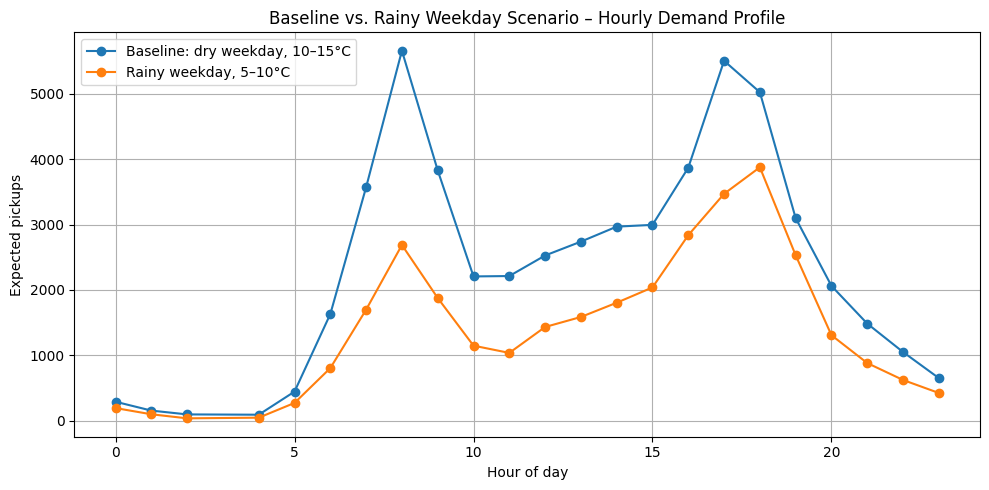

In [27]:
# --- Select baseline scenario: weekday, dry, 10–15°C ---
baseline_mask = (
    (master_business_view["day_type"] == "weekday") &
    (master_business_view["temp_bin"] == "10-15") &
    (master_business_view["rain_flag"] == "dry")
)

baseline_profile = (
    master_business_view[baseline_mask]
    .sort_values("hour")
    [["hour", "baseline_pickups"]]
    .drop_duplicates(subset=["hour"])  # ensure one row per hour
    .reset_index(drop=True)
)

# --- Select rainy scenario: weekday, rain, 5–10°C ---
rainy_mask = (
    (master_business_view["day_type"] == "weekday") &
    (master_business_view["temp_bin"] == "5-10") &
    (master_business_view["rain_flag"] == "rain")
)

rainy_profile = (
    master_business_view[rainy_mask]
    .sort_values("hour")
    [["hour", "expected_pickups"]]
    .drop_duplicates(subset=["hour"])
    .reset_index(drop=True)
)

# Align on common hours
profile_merged = baseline_profile.merge(
    rainy_profile,
    on="hour",
    how="inner",
    suffixes=("_baseline", "_rainy")
)

plt.figure(figsize=(10, 5))
plt.plot(
    profile_merged["hour"],
    profile_merged["baseline_pickups"],
    marker="o",
    label="Baseline: dry weekday, 10–15°C"
)
plt.plot(
    profile_merged["hour"],
    profile_merged["expected_pickups"],
    marker="o",
    label="Rainy weekday, 5–10°C"
)

plt.xlabel("Hour of day")
plt.ylabel("Expected pickups")
plt.title("Baseline vs. Rainy Weekday Scenario – Hourly Demand Profile")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    5.2 – Baseline vs. Warm Dry Weekend Scenario (Hourly Profile)
  </span>
</h3>

This step compares the expected hourly demand between:

- a baseline scenario (dry weekday, 10–15°C), and </br>
- a warm dry weekend scenario (25–30°C, dry).</br>

Using <code>master_business_view</code>, the code:

- extracts the hourly profile of <code>baseline_pickups</code> for the baseline weekday scenario,</br>
- extracts the hourly profile of <code>expected_pickups</code> for the warm dry weekend scenario,</br>
- merges the two profiles on the hour and plots both curves together.</br>

This visualisation highlights a very different demand pattern on warm weekends:</br>
weekday commuting peaks (08:00 and 17:00) disappear, while leisure-driven demand</br>
generates a strong midday–afternoon surge, often reaching two to three times the</br>
baseline values. </br>

The plot is particularly useful for operational planning, as warm weekends require:</br>

- increased fleet availability around midday and early afternoon,</br>
- more frequent rebalancing to address rapid bike turnover in popular areas, and</br>
- potentially additional staffing to handle higher service pressure.</br>


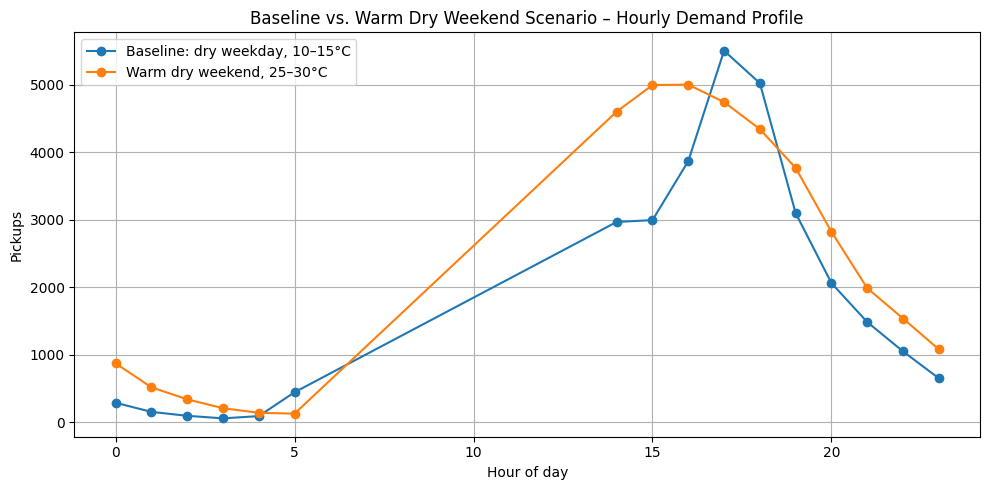

In [28]:
# --- Select baseline scenario: weekday, dry, 10–15°C ---
baseline_mask = (
    (master_business_view["day_type"] == "weekday") &
    (master_business_view["temp_bin"] == "10-15") &
    (master_business_view["rain_flag"] == "dry")
)

baseline_profile = (
    master_business_view[baseline_mask]
    .sort_values("hour")
    [["hour", "baseline_pickups"]]
    .drop_duplicates(subset=["hour"])
    .reset_index(drop=True)
)

# --- Select warm dry weekend scenario: weekend, dry, 25–30°C ---
warm_weekend_mask = (
    (master_business_view["day_type"] == "weekend") &
    (master_business_view["temp_bin"] == "25-30") &
    (master_business_view["rain_flag"] == "dry")
)

warm_weekend_profile = (
    master_business_view[warm_weekend_mask]
    .sort_values("hour")
    [["hour", "expected_pickups"]]
    .drop_duplicates(subset=["hour"])
    .reset_index(drop=True)
)

# Merge profiles
profile_merged = baseline_profile.merge(
    warm_weekend_profile,
    on="hour",
    how="inner"
)

# --- Plot ---
plt.figure(figsize=(10, 5))

plt.plot(
    profile_merged["hour"],
    profile_merged["baseline_pickups"],
    marker="o",
    label="Baseline: dry weekday, 10–15°C"
)

plt.plot(
    profile_merged["hour"],
    profile_merged["expected_pickups"],
    marker="o",
    label="Warm dry weekend, 25–30°C"
)

plt.xlabel("Hour of day")
plt.ylabel("Pickups")
plt.title("Baseline vs. Warm Dry Weekend Scenario – Hourly Demand Profile")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    5.3 – Scenario Demand Multipliers Heatmap
  </span>
</h3>

This step visualises the *average demand multiplier* for every scenario</br>
defined by:</br>

- **day type** (weekday / weekend),</br>
- **temperature bin**, and</br>
- **rain flag** (dry / rain / snow-like).</br>

Using the consolidated `scenario_rules_report` (or the scenario-level</br>
aggregations), the method builds a matrix where:</br>

- each **row** corresponds to a temperature bin,</br>
- each **column** corresponds to a (day_type, rain_flag) combination,</br>
- each **cell** shows the **avg demand multiplier** for that scenario.</br>

This heatmap provides a compact way to compare how weather and temperature</br>
affect relative demand levels across all conditions.  </br>
It can be used in the report to quickly communicate which combinations lead</br>
to unusually high or low system-wide demand.


C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\4159496884.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["temp_bin", "day_type", "rain_flag"])["demand_multiplier"]


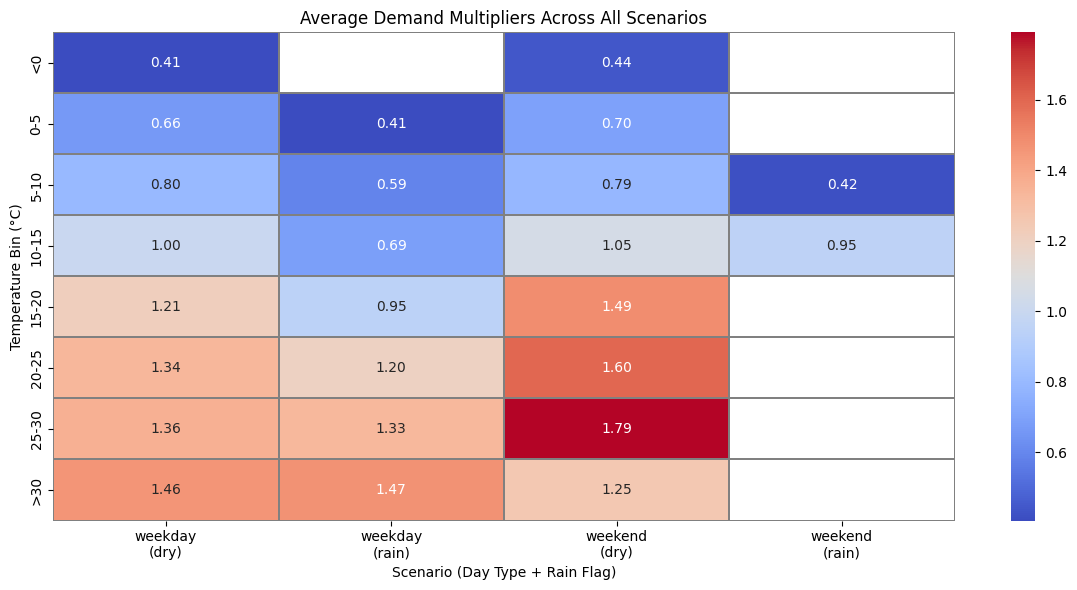

In [29]:
# --- Step 1: Prepare scenario averages for heatmap ---

# We compute avg multipliers for all scenarios that exist
heatmap_data = (
    master_business_view
    .groupby(["temp_bin", "day_type", "rain_flag"])["demand_multiplier"]
    .mean()
    .reset_index()
)

# Create a column combining day_type + rain_flag for readability
heatmap_data["scenario"] = heatmap_data["day_type"] + "\n(" + heatmap_data["rain_flag"] + ")"

# Pivot for heatmap (Rows = temp_bin, Cols = scenario, Values = avg multiplier)
heatmap_matrix = heatmap_data.pivot(
    index="temp_bin",
    columns="scenario",
    values="demand_multiplier"
)

# --- Step 2: Plot heatmap ---

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.3,
    linecolor="grey"
)

plt.title("Average Demand Multipliers Across All Scenarios")
plt.xlabel("Scenario (Day Type + Rain Flag)")
plt.ylabel("Temperature Bin (°C)")
plt.tight_layout()
plt.show()


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    5.4 – Rebalancing & Staffing Levels Across Scenarios
  </span>
</h3>

This step summarises the operational impact of each scenario by analysing</br>
how often the system requires:</br>

- **intense rebalancing** (high),  </br>
- **reduced rebalancing** (low),  </br>
- **normal rebalancing**,  </br>
- **peak staffing** (extra shift),  </br>
- **reduced staffing** (low demand hours).</br>

Using the `master_business_view`, the code:</br>

- groups the data by (<code>temp_bin</code>, <code>rain_flag</code>, <code>day_type</code>), </br> 
- counts how many hours fall into each operational category,  </br>
- normalises these counts to percentages,  </br>
- visualises the results in a pair of bar charts.</br>

These figures are useful to communicate how operational pressure changes</br>
under different weather and temperature scenarios.  </br>
For example, cold rainy weekdays may show:</br>
- more **low** staffing needs (reduced demand),  </br>
- more **normal** rebalancing hours,  </br>
while warm dry weekends may show:</br>
- more **peak** staffing hours,  </br>
- more **high** rebalancing needs.</br>

This step provides evidence-based recommendations for resource allocation.


In [30]:
# --- 1. Rebalancing summary ---

reb_summary = (
    master_business_view
    .groupby(["day_type", "temp_bin", "rain_flag", "rebalancing_level"])
    .size()
    .reset_index(name="hours")
)

# Convert to percentages within each scenario group
reb_summary["percent"] = (
    reb_summary
    .groupby(["day_type", "temp_bin", "rain_flag"])["hours"]
    .transform(lambda x: 100 * x / x.sum())
)

reb_summary.head()


C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\3191253124.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["day_type", "temp_bin", "rain_flag", "rebalancing_level"])
C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\3191253124.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["day_type", "temp_bin", "rain_flag"])["hours"]


,day_type,temp_bin,rain_flag,rebalancing_level,hours,percent
0,weekday,<0,dry,high,0,0.0
1,weekday,<0,dry,low,21,100.0
2,weekday,<0,dry,normal,0,0.0
3,weekday,<0,rain,high,0,NaN
4,weekday,<0,rain,low,0,NaN


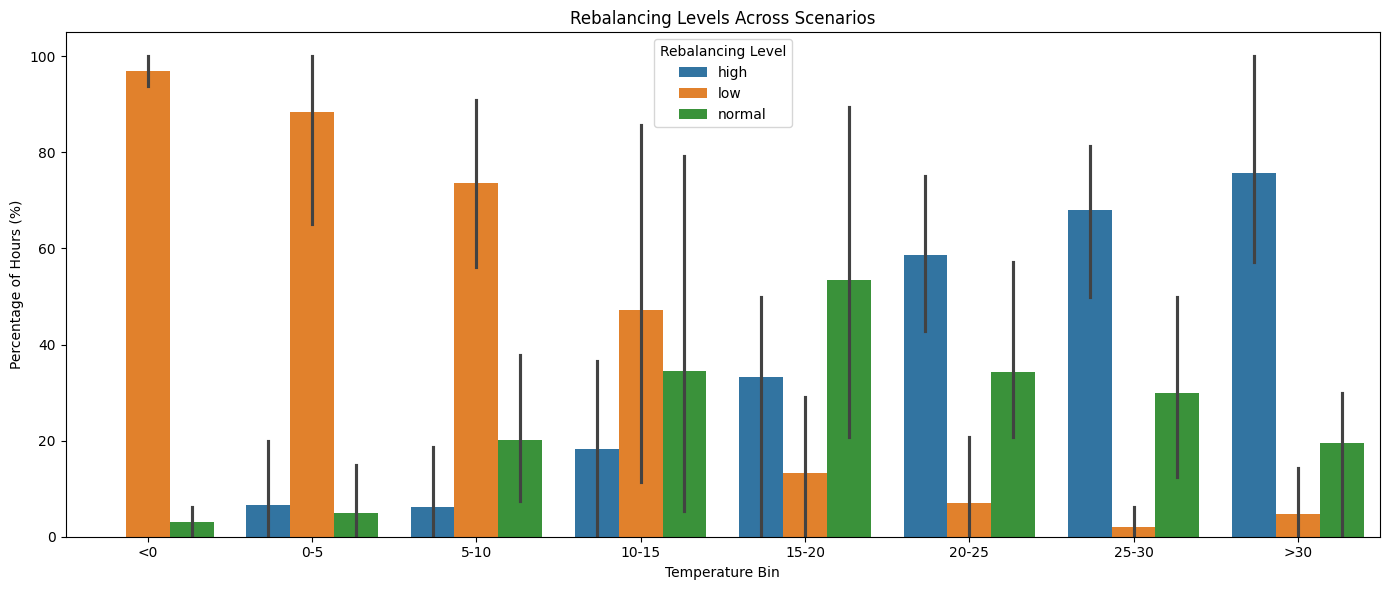

In [31]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=reb_summary,
    x="temp_bin",
    y="percent",
    hue="rebalancing_level"
)

plt.title("Rebalancing Levels Across Scenarios")
plt.ylabel("Percentage of Hours (%)")
plt.xlabel("Temperature Bin")
plt.legend(title="Rebalancing Level")
plt.tight_layout()
plt.show()


In [32]:
# --- 2. Staffing summary ---

staff_summary = (
    master_business_view
    .groupby(["day_type", "temp_bin", "rain_flag", "staffing_level"])
    .size()
    .reset_index(name="hours")
)

# Convert to percentages within each scenario group
staff_summary["percent"] = (
    staff_summary
    .groupby(["day_type", "temp_bin", "rain_flag"])["hours"]
    .transform(lambda x: 100 * x / x.sum())
)

staff_summary.head()


C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\3637291453.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["day_type", "temp_bin", "rain_flag", "staffing_level"])
C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\3637291453.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["day_type", "temp_bin", "rain_flag"])["hours"]


,day_type,temp_bin,rain_flag,staffing_level,hours,percent
0,weekday,<0,dry,normal,0,0.0
1,weekday,<0,dry,peak_extra_shift,0,0.0
2,weekday,<0,dry,reduced_shift,21,100.0
3,weekday,<0,rain,normal,0,NaN
4,weekday,<0,rain,peak_extra_shift,0,NaN


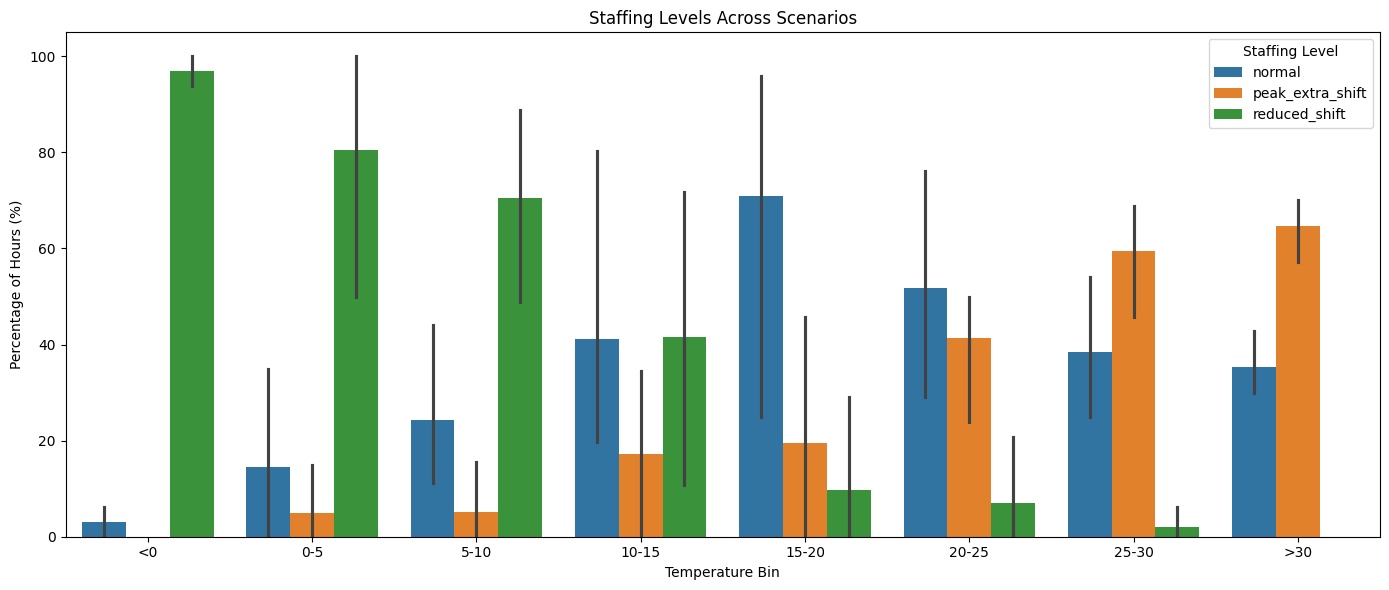

In [33]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=staff_summary,
    x="temp_bin",
    y="percent",
    hue="staffing_level"
)

plt.title("Staffing Levels Across Scenarios")
plt.ylabel("Percentage of Hours (%)")
plt.xlabel("Temperature Bin")
plt.legend(title="Staffing Level")
plt.tight_layout()
plt.show()


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    5.5 – Full Scenario Comparison Table (Summary for Report Appendix)
  </span>
</h3>

This step produces a consolidated comparison table that summarises all</br>
scenario categories across the dataset.  </br>
Using the cleaned <code>master_business_view</code>, the code aggregates:</br>

- the **average demand multiplier**,  </br>
- the **minimum and maximum multiplier**,  </br>
- the **average expected pickups**,  </br>
- the **typical rebalancing level**,  </br>
- the **typical staffing level**,  </br>
- the total number of hours available in each scenario.</br>

Each row corresponds to a unique combination of:</br>
- <code>day_type</code> (weekday / weekend)  </br>
- <code>temp_bin</code> (temperature bucket)  </br>
- <code>rain_flag</code> (dry / rain / snow_like)</br>

This table is extremely useful for the report because it provides:</br>
- a high-level view of how demand changes across weather scenarios,  </br>
- operational insights for staffing and rebalancing,  </br>
- a quantitative basis for scenario selection in later chapters.</br>

You can include this table as an appendix in the report, or filter it</br>
to highlight only the most relevant scenarios.


In [34]:
def summarize_all_scenarios(df):
    """
    Builds a full scenario comparison table from master_business_view.
    One row per: (day_type, temp_bin, rain_flag)
    """
    rows = []

    for (dt, tb, rf), sub in df.groupby(["day_type", "temp_bin", "rain_flag"]):
        rows.append({
            "day_type": dt,
            "temp_bin": tb,
            "rain_flag": rf,
            "avg_multiplier": sub["demand_multiplier"].mean(),
            "min_multiplier": sub["demand_multiplier"].min(),
            "max_multiplier": sub["demand_multiplier"].max(),
            "avg_expected_pickups": sub["expected_pickups"].mean(),
            "typical_rebalancing": sub["rebalancing_level"].mode().iloc[0],
            "typical_staffing": sub["staffing_level"].mode().iloc[0],
            "n_hours": len(sub)
        })

    return pd.DataFrame(rows).sort_values(
        ["day_type", "temp_bin", "rain_flag"]
    ).reset_index(drop=True)

scenario_comparison_table = summarize_all_scenarios(master_business_view)
scenario_comparison_table


C:\Users\Georg\AppData\Local\Temp\ipykernel_10564\3326506931.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (dt, tb, rf), sub in df.groupby(["day_type", "temp_bin", "rain_flag"]):


,day_type,temp_bin,rain_flag,avg_multiplier,min_multiplier,max_multiplier,avg_expected_pickups,typical_rebalancing,typical_staffing,n_hours
0,weekday,0-5,dry,0.662730,0.580341,0.778065,1476.856441,low,reduced_shift,24
1,weekday,0-5,rain,0.406802,0.321156,0.549846,919.637102,low,reduced_shift,23
2,weekday,10-15,dry,1.000000,1.000000,1.000000,2259.048695,normal,normal,24
3,weekday,10-15,rain,0.685098,0.507776,0.799430,1680.921266,low,reduced_shift,22
4,weekday,15-20,dry,1.213877,1.068867,1.488637,2693.645549,high,normal,24
5,weekday,15-20,rain,0.946647,0.763998,1.199636,2149.580409,normal,normal,19
6,weekday,20-25,dry,1.335821,1.035616,1.672286,2908.346262,high,normal,24
7,weekday,20-25,rain,1.199739,0.880670,1.671511,2837.449490,normal,normal,21
8,weekday,25-30,dry,1.361600,1.004777,1.956315,2817.341253,high,normal,24
9,weekday,25-30,rain,1.327555,0.879675,1.654966,2920.189741,high,peak_extra_shift,11


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    5.6 – Export of Scenario Tables to Disk
  </span>
</h3>

This step exports all scenario-related tables to disk so they can be used</br>
in the report, shared with stakeholders, or imported into other analysis</br>
tools.</br>

The following tables are saved:</br>

- <code>master_business_view</code> – full hourly scenario dataset  </br>
- <code>scenario_comparison_table</code> – one row per scenario category  </br>
- <code>scenario_rules_report</code> – curated subset of key scenarios  </br>

All files are written in both CSV and Excel formats under:</br>

<code>../data/Weather_Data/scenario_outputs/</code></br>

This ensures reproducibility of results, easier debugging, and clean</br>
integration into the final written report.

In [35]:
# --- Create output folder ---
output_dir = "../data/Weather_Data/scenario_outputs/"
os.makedirs(output_dir, exist_ok=True)

# --- Define CSV file paths ---
path_master_csv  = os.path.join(output_dir, "master_business_view.csv")
path_compare_csv = os.path.join(output_dir, "scenario_comparison_table.csv")
path_rules_csv   = os.path.join(output_dir, "scenario_rules_report.csv")

# --- Export master_business_view ---
master_business_view.to_csv(path_master_csv, index=False)

# --- Export scenario comparison table ---
scenario_comparison_table.to_csv(path_compare_csv, index=False)

# --- Export rules report ---
scenario_rules_report.to_csv(path_rules_csv, index=False)

print("CSV export completed successfully!")
print("Files saved to:", output_dir)

CSV export completed successfully!
Files saved to: ../data/Weather_Data/scenario_outputs/


<h3>
  <span style="color:green; font-weight:bold; background-color:#f0f0f0; padding:6px; border-radius:4px; font-size:20px;">
    5.7 – Export of Clean Weather Dataset for Cluster-Based Analysis
  </span>
</h3>

In addition to the scenario tables exported in step 5.6, we also save a </br>
clean hourly weather–demand dataset which will be reused in the next notebook
(<code>02_cluster_weather_scenarios.ipynb</code>).

This dataset contains:

- hourly timestamps,
- cleaned temperature values,
- precipitation levels,
- rain/dry/snow flags,
- time features (hour, day-of-week, weekend, month),
- and hourly pickups.

It represents the *raw material* required to build cluster-level scenario </br>
tables, where demand patterns are analysed separately for each spatial cluster </br>
of stations. Saving it to disk ensures reproducibility and clean separation </br>
between the city-wide and cluster-based analysis steps.

All files are saved under:

<code>../data/Weather_Data/weather_core/</code>

so they do not interfere with the scenario output folder.


In [36]:
# --- Create output folder for weather core dataset ---
weather_core_dir = "../data/Weather_Data/weather_core/"
os.makedirs(weather_core_dir, exist_ok=True)

# --- Define export paths ---
path_demand_core = os.path.join(weather_core_dir, "demand_core.csv")
path_weather_clean = os.path.join(weather_core_dir, "weather_hourly_clean.csv")

# --- Export the full demand_core (weather + pickups + flags + time features) ---
demand_core.to_csv(path_demand_core, index=False)

# --- Export weather-only subset for cleaner merging later ---
weather_cols = [
    "datetime_hour", "temp_C", "precip_in",
    "is_rain", "is_snow_like", "is_dry",
    "hour", "dow", "is_weekend", "month"
]

demand_core[weather_cols].to_csv(path_weather_clean, index=False)

print("Weather core datasets exported successfully!")
print("Saved files:")
print("-", path_demand_core)
print("-", path_weather_clean)

Weather core datasets exported successfully!
Saved files:
- ../data/Weather_Data/weather_core/demand_core.csv
- ../data/Weather_Data/weather_core/weather_hourly_clean.csv


In [37]:
def query_scenario(day_type, temp_bin, rain_flag, pretty=True):
    """
    Query a scenario and return nicely formatted business insights
    or a raw dictionary if pretty=False.
    """

    df = master_business_view.copy()

    # Filter based on scenario parameters
    mask = (
        (df["day_type"] == day_type) &
        (df["temp_bin"] == temp_bin) &
        (df["rain_flag"] == rain_flag)
    )
    sub = df[mask]

    if sub.empty:
        return f"[NO DATA] No matching scenario for ({day_type}, {temp_bin}, {rain_flag})", sub

    # Collect results
    result = {
        "scenario": f"{day_type}, {temp_bin}°C, {rain_flag}",
        "avg_expected_pickups": float(sub["expected_pickups"].mean()),
        "avg_multiplier": float(sub["demand_multiplier"].mean()),
        "min_multiplier": float(sub["demand_multiplier"].min()),
        "max_multiplier": float(sub["demand_multiplier"].max()),
        "typical_staffing": sub["staffing_level"].mode().iloc[0],
        "typical_rebalancing": sub["rebalancing_level"].mode().iloc[0],
        "hours_in_dataset": int(len(sub))
    }

    # Pretty formatted block
    pretty_output = f"""
===============================
 SCENARIO SUMMARY
===============================
 Scenario:           {result['scenario']}
 Historical support: {result['hours_in_dataset']} hours

--- Demand Impact ---
 Average expected pickups: {result['avg_expected_pickups']:.0f}
 Average multiplier:        {result['avg_multiplier']:.2f}
 Minimum multiplier:        {result['min_multiplier']:.2f}
 Maximum multiplier:        {result['max_multiplier']:.2f}

--- Operational Impact ---
 Typical staffing level:    {result['typical_staffing']}
 Typical rebalancing level: {result['typical_rebalancing']}
===============================
"""

    if pretty:
        return pretty_output, sub
    else:
        return result, sub


In [38]:
import matplotlib.pyplot as plt

def plot_scenario_curve(subset, label=None):
    """
    Plot expected pickups vs hour for a selected scenario.
    """

    if subset.empty:
        print("[WARN] Empty subset — cannot plot.")
        return

    df = subset.sort_values("hour")

    plt.figure(figsize=(10, 4))
    plt.plot(df["hour"], df["expected_pickups"], marker="o")

    plt.title(label if label else "Scenario Demand Curve")
    plt.xlabel("Hour of day")
    plt.ylabel("Expected pickups")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



 SCENARIO SUMMARY
 Scenario:           weekday, 5-10°C, rain
 Historical support: 23 hours

--- Demand Impact ---
 Average expected pickups: 1422
 Average multiplier:        0.59
 Minimum multiplier:        0.37
 Maximum multiplier:        0.82

--- Operational Impact ---
 Typical staffing level:    reduced_shift
 Typical rebalancing level: low



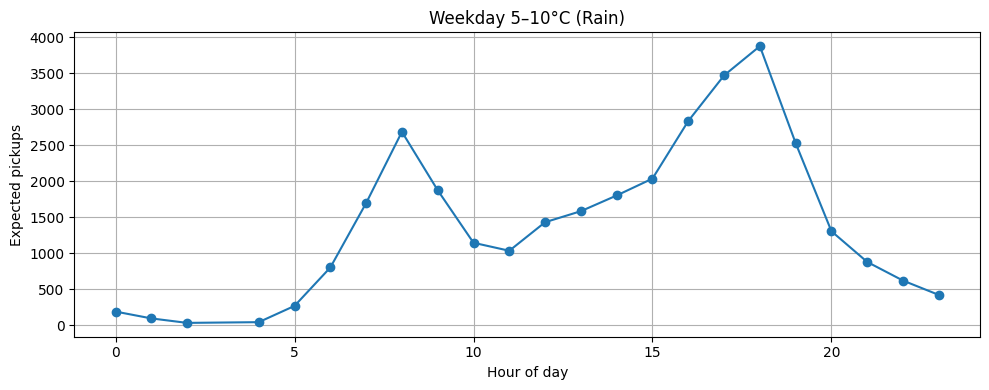

In [39]:
# Example: rainy weekday, 5–10°C
summary, sub = query_scenario("weekday", "5-10", "rain", pretty=True)
print(summary)

plot_scenario_curve(sub, label="Weekday 5–10°C (Rain)")
